<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/AE_fourier%2Bcorrelation_reconstruction_simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# === General Purpose ===
import os
import glob
import re
import random
import numpy as np
import matplotlib.pyplot as plt

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import load_model as keras_load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# === Sklearn ===
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

# === Signal Processing ===
from scipy.signal import welch, csd, coherence, stft

# === Set Seeds for Reproducibility ===
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# === Google Colab Mount ===
from google.colab import drive
drive.mount('/content/drive')

# === Working Directory Setup ===
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
def normalize_and_swap(data):
    stds = np.std(data, axis=-1, keepdims=True)
    normed = data / stds
    return np.swapaxes(data, 1, 2), np.swapaxes(normed, 1, 2)

# === Background ===
BG = np.load('O3_Background_dataset.npz')

BG_train = BG['data'][:-1024]
BG_train, BG_train_normed = normalize_and_swap(BG_train)

BG_test = BG['data'][-1024:]
BG_test, BG_test_normed = normalize_and_swap(BG_test)

# === Signal Set ===
signal = np.load('O3_rescaled_signals_dataset.npz')
snr = signal['snr']
signal_label = signal['label']

# SineGaussian
SG_index = np.where(signal_label == 2)
# SG_index = np.intersect1d(SG_index, seven)
SG = signal['data'][SG_index]
SG, SG_normed = normalize_and_swap(SG)

# BBH
BBH_index = np.where(signal_label == 3)
# BBH_index = np.intersect1d(BBH_index, seven)
BBH = signal['data'][BBH_index]
BBH, BBH_normed = normalize_and_swap(BBH)

# Gaussian
Gaussian_index = np.where(signal_label == 4)
# Gaussian_index = np.intersect1d(Gaussian_index, seven)
Gaussian = signal['data'][Gaussian_index]
Gaussian, Gaussian_normed = normalize_and_swap(Gaussian)

# Cusp
Cusp_index = np.where(signal_label == 5)
# Cusp_index = np.intersect1d(Cusp_index, seven)
Cusp = signal['data'][Cusp_index]
Cusp, Cusp_normed = normalize_and_swap(Cusp)

# Kink
Kink_index = np.where(signal_label == 6)
# Kink_index = np.intersect1d(Kink_index, seven)
Kink = signal['data'][Kink_index]
Kink, Kink_normed = normalize_and_swap(Kink)

# KinkKink
KinkKink_index = np.where(signal_label == 7)
# KinkKink_index = np.intersect1d(KinkKink_index, seven)
KinkKink = signal['data'][KinkKink_index]
KinkKink, KinkKink_normed = normalize_and_swap(KinkKink)

# WNB
WNB_index = np.where(signal_label == 8)
# WNB_index = np.intersect1d(WNB_index, seven)
WNB = signal['data'][WNB_index]
WNB, WNB_normed = normalize_and_swap(WNB)

In [105]:
print('shape for background train/test' , BG_train.shape, BG_test.shape)
print('shape for SG ' , SG.shape)
print('shape for BBH ' , BBH.shape)
print('shape for Gaussian ' , Gaussian.shape)
print('shape for Cusp ' , Cusp.shape)
print('shape for Kink ' , Kink.shape)
print('shape for KinkKink ' , KinkKink.shape)
print('shape for WNB ' , WNB.shape)

shape for background train/test (254976, 200, 2) (1024, 200, 2)
shape for SG  (1036, 200, 2)
shape for BBH  (1022, 200, 2)
shape for Gaussian  (1022, 200, 2)
shape for Cusp  (1022, 200, 2)
shape for Kink  (1022, 200, 2)
shape for KinkKink  (1022, 200, 2)
shape for WNB  (1022, 200, 2)


In [106]:
def add_correlation_channel(x):
    x1, x2 = x[:, :, 0], x[:, :, 1]
    corr = np.array([
        np.correlate(x1[i], x2[i], mode='same') for i in range(x.shape[0])
    ])
    return np.stack([x1, x2, corr], axis=-1)

def compute_correlation_array(x):
    return np.array([
        np.correlate(x[i, :, 0], x[i, :, 1], mode='same') for i in range(x.shape[0])
    ])

# === With correlation channel (not normalized) ===
# BG_train = add_correlation_channel(BG_train)
# BG_test = add_correlation_channel(BG_test)
# SG = add_correlation_channel(SG)
# BBH = add_correlation_channel(BBH)
# Gaussian = add_correlation_channel(Gaussian)
# Cusp = add_correlation_channel(Cusp)
# Kink = add_correlation_channel(Kink)
# KinkKink = add_correlation_channel(KinkKink)
# WNB = add_correlation_channel(WNB)

# === With correlation channel (normalized) ===
# BG_train = add_correlation_channel(BG_train_normed)
# BG_test = add_correlation_channel(BG_test_normed)
# SG = add_correlation_channel(SG_normed)
# BBH = add_correlation_channel(BBH_normed)
# Gaussian = add_correlation_channel(Gaussian_normed)
# Cusp = add_correlation_channel(Cusp_normed)
# Kink = add_correlation_channel(Kink_normed)
# KinkKink = add_correlation_channel(KinkKink_normed)
# WNB = add_correlation_channel(WNB_normed)

# === Correlation targets (not normalized) ===
# BG_train_corr = compute_correlation_array(BG_train)
# BG_test_corr = compute_correlation_array(BG_test)
# SG_corr = compute_correlation_array(SG)
# BBH_corr = compute_correlation_array(BBH)
# Gaussian_corr = compute_correlation_array(Gaussian)
# Cusp_corr = compute_correlation_array(Cusp)
# Kink_corr = compute_correlation_array(Kink)
# KinkKink_corr = compute_correlation_array(KinkKink)
# WNB_corr = compute_correlation_array(WNB)

# === Correlation targets (normalized) ===
BG_train_corr = compute_correlation_array(BG_train_normed)
BG_test_corr = compute_correlation_array(BG_test_normed)
SG_corr = compute_correlation_array(SG_normed)
BBH_corr = compute_correlation_array(BBH_normed)
Gaussian_corr = compute_correlation_array(Gaussian_normed)
Cusp_corr = compute_correlation_array(Cusp_normed)
Kink_corr = compute_correlation_array(Kink_normed)
KinkKink_corr = compute_correlation_array(KinkKink_normed)
WNB_corr = compute_correlation_array(WNB_normed)


In [107]:
def compute_csd_psd(x, fs=4096, nperseg=200):
    """Compute absolute cross power spectral density between channel 0 and 1."""
    _, psd = csd(x[:, :, 0], x[:, :, 1], fs=fs, nperseg=nperseg)
    return np.abs(psd)

def compute_stft(x, fs=4096, nperseg=7):
    """Compute STFT (time-frequency representation) of channel 0."""
    _, _, Zxx = stft(x[:, :, 0], fs=fs, nperseg=nperseg)
    return Zxx  # Use np.abs(Zxx) if you want magnitude


fs = 4096
# === PSD using CSD ===
##--background_psd--##
BG_train_psd = compute_csd_psd(BG_train, fs)
BG_test_psd = compute_csd_psd(BG_test, fs)

##--BBH_psd--##
BBH_psd = compute_csd_psd(BBH, fs)

##--SG_psd--##
SG_psd = compute_csd_psd(SG, fs)

##--Gaussian_psd--##
Gaussian_psd = compute_csd_psd(Gaussian, fs)

##--Cusp_psd--##
Cusp_psd = compute_csd_psd(Cusp, fs)

##--Kink_psd--##
Kink_psd = compute_csd_psd(Kink, fs)

##--KinkKink_psd--##
KinkKink_psd = compute_csd_psd(KinkKink, fs)

##--WNB_psd--##
WNB_psd = compute_csd_psd(WNB, fs)

# === STFT ===
nperseg = 7

##--BG_stft--##
BG_train_stft = compute_stft(BG_train, fs, nperseg)
# BG_train_stft = abs(BG_train_stft)
BG_test_stft = compute_stft(BG_test, fs, nperseg)
# BG_test_stft = abs(BG_test_stft)

##--BBH_stft--##
BBH_stft = compute_stft(BBH, fs, nperseg)
# BBH_stft = abs(BBH_stft)

##--SG_stft--##
SG_stft = compute_stft(SG, fs, nperseg)
# SG_stft = abs(SG_stft)

##--Gaussian_stft--##
Gaussian_stft = compute_stft(Gaussian, fs, nperseg)
# Gaussian_stft = abs(Gaussian_stft)

##--Cusp--##
Cusp_stft = compute_stft(Cusp, fs, nperseg)
# Cusp_stft = abs(Cusp_stft)

##--Kink--##
Kink_stft = compute_stft(Kink, fs, nperseg)
# Kink_stft = abs(Kink_stft)

##--KinkKink--##
KinkKink_stft = compute_stft(KinkKink, fs, nperseg)
# KinkKink_stft = abs(KinkKink_stft)

##--WNB--##
WNB_stft = compute_stft(WNB, fs, nperseg)
# WNB_stft = abs(WNB_stft)


SOLUTION GIVEN

In [108]:
tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200, 2), dropout=0.1, batch_size=256, epochs=50, lr=1e-3,
                 f1=3, f2=16, f3=32, f4=64, k1=16, k2=32, k3=64, k4=128, s1=2, s2=2, s3=1, s4=1):
        self.input_shape = input_shape
        self.f1, self.f2, self.f3, self.f4 = f1, f2, f3, f4
        self.k1, self.k2, self.k3, self.k4 = k1, k2, k3, k4
        self.s1, self.s2, self.s3, self.s4 = s1, s2, s3, s4
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model_ = None

    # def positional_encoding(self, inputs):
    #     embed_size = inputs.shape[-1]
    #     input_length = inputs.shape[-2]
    #     assert embed_size % 2 == 0, 'embed_size must be even'
    #     p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
    #     pos_emb = np.empty((1, input_length, embed_size))
    #     pos_emb[0, :, ::2] = np.sin(p / (10000 ** (2 * i / embed_size))).T
    #     pos_emb[0, :, 1::2] = np.cos(p / (10000 ** (2 * i / embed_size))).T
    #     self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
    #     return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape = self.input_shape)

        x = inputs

        # 1. Shared temporal feature extraction
        x = layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
        x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.Dropout(self.dropout)(x)

        # 2. Flatten and regress to correlation shape
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        outputs = layers.Dense(200, activation='linear', name="correlation_output")(x)

        self.model_ = keras.Model(inputs, outputs)
        self.model_.compile(optimizer=keras.optimizers.Adam(learning_rate=self.lr), loss="mse")


    # def build_dense_stft_head(self, x, name):
    #     x_flat = layers.Flatten()(x)
    #     x_dense = layers.Dense(np.prod(self.stft_shape))(x_flat)
    #     x_reshaped = layers.Reshape(self.stft_shape)(x_dense)
    #     x_out = layers.Conv1D(self.stft_shape[1], kernel_size=1, padding='same', name=name)(x_reshaped)
    #     return x_out

    # def build_model(self):
    #     inputs = keras.Input(shape=self.input_shape)
    #     x = inputs

    #     # Encoder
    #     x = layers.Conv1D(self.f1, self.k1, self.s1, padding="same", activation="tanh")(x)
    #     x = layers.Dropout(self.dropout)(x)
    #     x = layers.Conv1D(self.f2, self.k2, self.s2, padding="same", activation="tanh")(x)
    #     x = layers.Conv1D(self.f3, self.k3, self.s3, padding="same", activation="tanh")(x)

    #     # Bottleneck
    #     latent_x = layers.Conv1D(self.f4, self.k4, self.s4, padding="same")(x)
    #     latent_x = layers.Dropout(self.dropout)(latent_x)

    #     # Decoder
    #     x = layers.Conv1DTranspose(self.f3, self.k3, self.s3, padding="same")(latent_x)
    #     x = layers.Conv1DTranspose(self.f2, self.k2, self.s2, padding="same")(x)
    #     decoder_output = layers.Conv1DTranspose(self.f1, self.k1, strides=1, padding="same", name="reconstructed_signal")(x)

    #     # STFT Heads
    #     stft_x_output = self.build_dense_stft_head(latent_x, name="predicted_x_stft")
    #     stft_y_output = self.build_dense_stft_head(latent_x, name="predicted_y_stft")

    #     # Correlation Head
    #     corr = layers.Flatten()(latent_x)
    #     corr = layers.Dense(400, activation="relu")(corr)
    #     corr = layers.Dense(300, activation="relu")(corr)
    #     correlation_output = layers.Dense(200, activation="relu", name="correlation_output")(corr)

    #     # Model
    #     self.model_ = keras.Model(inputs, outputs={
    #         "reconstructed_signal": decoder_output,
    #         "predicted_x_stft": stft_x_output,
    #         "predicted_y_stft": stft_y_output,
    #         "correlation_output": correlation_output
    #     })

    #     self.model_.compile(
    #         optimizer=keras.optimizers.Adam(learning_rate=self.lr),
    #         loss={
    #             "reconstructed_signal": "mse",
    #             "predicted_x_stft": "mse",
    #             "predicted_y_stft": "mse",
    #             "correlation_output": "mse"
    #         },
    #         loss_weights={
    #             "reconstructed_signal": 1.0,
    #             "predicted_x_stft": 0.0,
    #             "predicted_y_stft": 0.0,
    #             "correlation_output": 1.0
    #         }
    #     )

    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [109]:
# === Define parameter set ===
param_set = [
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 3,
     'k1': 16, 'k2': 32, 'k3': 64, 'k4': 128, 'k5': 5, 'lr': 0.001, 's1': 2, 's2': 2},

        # Symmetric design with 4 conv layers; tested both with and without correlation
    {'batch_size': 700, 'dropout': 0, 'epochs': 50, 'f1': 2, 'f2': 8, 'f3': 32, 'f4': 64,
     'k1': 4, 'k2': 8, 'k3': 16, 'k4': 32, 'lr': 0.0001, 's1': 1, 's2': 2, 's3': 2, 's4': 1}
]

params = param_set[1]  # Select parameter set

# === Initialize model ===
AE = Autoencoder(input_shape=(200, 2), **params)
# AE = Autoencoder(input_shape=(200, 3), **params)  # Uncomment for 3-channel input

AE.build_model()

# === Optional: define early stopping
early_stop = EarlyStopping(monitor='correlation_output_loss', patience=10, restore_best_weights=True)

# === Train the model
AE.model_.fit(
    BG_train,
    BG_train_corr,
    epochs=AE.epochs,
    batch_size=AE.batch_size,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stop]
)

# === Alternative: single-output baseline
# AE.model_.fit(
#     BG_train,
#     BG_train,
#     epochs=AE.epochs,
#     batch_size=AE.batch_size,
#     validation_split=0.2,
#     verbose=1,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
# )


Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 175.1247 - val_loss: 152.0938
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 150.9341 - val_loss: 148.1965
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 147.1647 - val_loss: 144.9403
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 144.1688 - val_loss: 143.2915
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 142.7520 - val_loss: 142.4811
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 142.0160 - val_loss: 141.9512
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 141.5235 - val_loss: 141.5473
Epoch 8/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 141.1328 - val_loss: 141.1867
Epoch 9/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 140.7651 - val_loss: 140.8230
Epoch 10/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 140.3933 - val_loss: 140.4636
Epoch 11/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 140.0198 - val_l

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


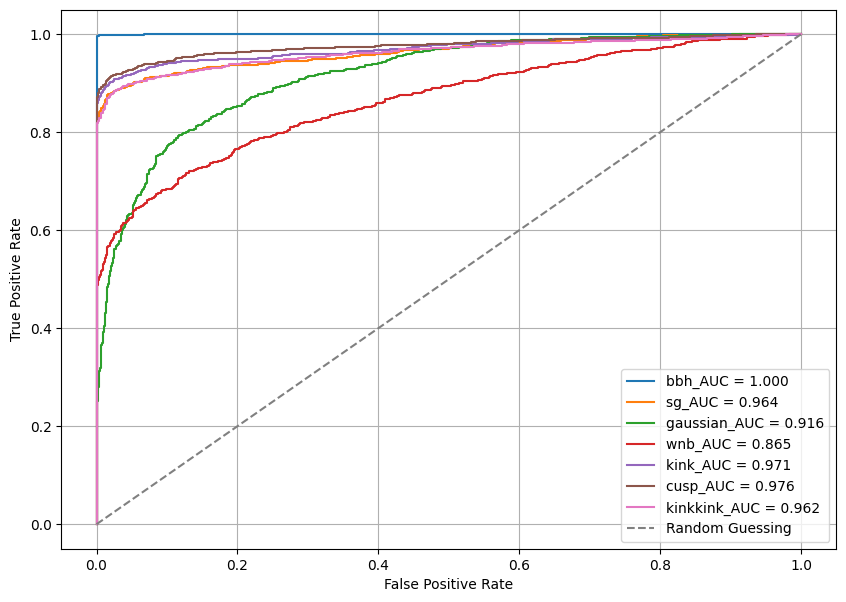

In [110]:
def getfpr_tpr(model, bg_mse, anomaly, anomaly_corr):
    anomaly_pred = model.predict(anomaly)
    anomaly_mse = np.mean((anomaly_pred - anomaly_corr) ** 2, axis=1)

    true_val = np.concatenate([np.zeros(len(bg_mse)), np.ones(len(anomaly_mse))])
    pred_val = np.concatenate([bg_mse, anomaly_mse])

    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    return fpr, tpr, thresholds, auc(fpr, tpr)

def eval(model, bg, bg_corr, signals):
    # Precompute background MSE
    bg_pred = model.predict(bg)
    bg_mse = np.mean((bg_pred - bg_corr) ** 2, axis=1)

    aucs = {}
    plt.figure(figsize=(10, 7))

    for name, (sig, sig_corr) in signals.items():
        fpr, tpr, _, auc_val = getfpr_tpr(model, bg_mse, sig, sig_corr)
        aucs[name] = auc_val
        plt.plot(fpr, tpr, label=f'{name}_AUC = {auc_val:.3f}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    return aucs

signals = {
    'bbh': (BBH, BBH_corr),
    'sg': (SG, SG_corr),
    'gaussian': (Gaussian, Gaussian_corr),
    'wnb': (WNB, WNB_corr),
    'kink': (Kink, Kink_corr),
    'cusp': (Cusp, Cusp_corr),
    'kinkkink': (KinkKink, KinkKink_corr)
}

aucs = eval(AE, BG_test, BG_test_corr, signals)

In [111]:
def recon_eval(model, bg, anomaly,label):
    bg_pred = model.predict(bg)['reconstructed_signal']
    anomaly_pred = model.predict(anomaly)['reconstructed_signal']
    bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
    anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=f'AUC = {auc_score:.3f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve of {label}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return auc_score

def stft_eval(model, bg, anomaly, bg_stft, anomaly_stft, label):
    bg_pred = model.predict(bg)['predicted_x_stft']+1j*model.predict(bg)['predicted_y_stft']
    anomaly_pred = model.predict(anomaly)['predicted_x_stft']+1j*model.predict(anomaly)['predicted_y_stft']
    bg_mse = np.mean((bg_pred - bg_stft)**2, axis=(1,2))
    anomaly_mse = np.mean((anomaly_pred - anomaly_stft)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, abs(pred_val))
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=f'AUC = {auc_score:.3f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve of {label}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return auc_score

In [112]:
# eval(AE, BG_test, BG_test_corr, BBH, BBH_corr ,'bbh')
# eval(AE, BG_test, BG_test_corr, SG, SG_corr ,'sglf')
# eval(AE, BG_test, BG_test_corr, WNB, WNB_corr ,'WNB')
# eval(AE, BG_test, BG_test_corr, Gaussian, Gaussian_corr ,'gaussian')
# eval(AE, BG_test, BG_test_corr, Cusp, Cusp_corr ,'cusp')
# eval(AE, BG_test, BG_test_corr, Kink, Kink_corr ,'kink')
# eval(AE, BG_test, BG_test_corr, KinkKink, KinkKink_corr ,'kinkkink')


In [113]:
# stft_eval(AE, BG_test, WNB, BG_test_stft, WNB_stft, 'WNB')
# stft_eval(AE, BG_test, Kink, BG_test_stft, Kink_stft, 'kinks')
# stft_eval(AE, BG_test, Cusp, BG_test_stft, Cusp_stft, 'cusps')
# stft_eval(AE, BG_test, Gaussian, BG_test_stft, Gaussian_stft, 'gaussian')
# stft_eval(AE, BG_test, KinkKink, BG_test_stft, KinkKink_stft, 'kinkkink')
# stft_eval(AE, BG_test, BBH, BG_test_stft, BBH_stft, 'bbh')
# stft_eval(AE, BG_test, SG, BG_test_stft, SG_stft, 'sglf')


In [114]:
# recon_eval(AE, BG_test, BBH, 'bbh')
# recon_eval(AE, BG_test, SG, 'sglf')
# recon_eval(AE, BG_test, WNB, 'WNB')
# recon_eval(AE, BG_test, Kink, 'kinks')
# recon_eval(AE, BG_test, Cusp, 'cusps')
# recon_eval(AE, BG_test, Gaussian, 'gaussian')
# recon_eval(AE, BG_test, KinkKink, 'kinkkink')


In [115]:
# save_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'

# param_set = [
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 61, 'f2': 22, 'f5': 2, 'k1': 9,  'k2': 15, 'k3': 24, 'k4': 4,  'k5': 6,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 52, 'f2': 29, 'f5': 2, 'k1': 16, 'k2': 6,  'k3': 8,  'k4': 25, 'k5': 4,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 36, 'f2': 29, 'f5': 2, 'k1': 7,  'k2': 14, 'k3': 15, 'k4': 7,  'k5': 3,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 60, 'f2': 21, 'f5': 2, 'k1': 10, 'k2': 34, 'k3': 26, 'k4': 3,  'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 38, 'f2': 28, 'f5': 2, 'k1': 22, 'k2': 21, 'k3': 27, 'k4': 31, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 40, 'f2': 14, 'f5': 2, 'k1': 4,  'k2': 8,  'k3': 20, 'k4': 29, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}
# ]

# for i, params in enumerate(param_set):
#     autoencoder = Autoencoder(**params, input_shape=(200, 2))
#     autoencoder.build_model()
#     autoencoder.model_.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         verbose=1,
#         callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
#     )
#     autoencoder.model_.save(f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{i}.keras")
#     print(f"✅ Saved model_{i}.keras")

In [116]:
# def eval(model, bg, anomaly):
#     bg_pred = model.predict(bg)
#     anomaly_pred = model.predict(anomaly)
#     bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
#     anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))

#     true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
#     pred_val = np.concatenate((bg_mse, anomaly_mse))

#     fpr, tpr, thresholds = roc_curve(true_val, pred_val)
#     auc_score = auc(fpr, tpr)
#     return auc_score

# # def eval(model, bg, anomaly):
# #     bg_pred = model.predict(bg)
# #     anomaly_pred = model.predict(anomaly)

# #     bg_mse = np.mean((bg_pred - bg) ** 2, axis=(1, 2))
# #     anomaly_mse = np.mean((anomaly_pred - anomaly) ** 2, axis=(1, 2))

# #     true_val = np.concatenate((np.zeros(bg.shape[0]), np.ones(anomaly.shape[0])))
# #     pred_val = np.concatenate((bg_mse, anomaly_mse))

# #     auc = roc_auc_score(true_val, pred_val)
# #     return auc

# model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_*.keras")
# model_files = sorted(model_files, key=lambda x: int(re.search(r"model_(\d+).keras", x).group(1)))
# for model_file in model_files:
#     model = keras_load_model(model_file)
#     auc_bbh = eval(model,background_test,bbh_test)
#     auc_sglf = eval(model,background_test,sglf_test)
#     auc_test = eval(model,background_test_data, signal_test_data)
#     print(f"✅ Evaluation of model {model_file}: BBH AUC = {auc_bbh}, SG AUC = {auc_sglf}, Test AUC = {auc_test}")

